# Load images to be used for training

Number of car images in labeled data set: 8792
Number of not car images in labeled data set: 8968


Text(0.5, 1.0, 'not car')

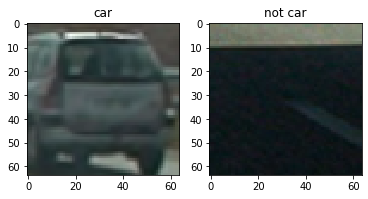

In [1]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def get_images_in_dir(dir):
    l = []
    for path, subdirs, files in os.walk(dir):
        for name in files:
            if name.endswith('.png'):
                l.append(os.path.join(path, name))                
    return l
                
car_list = get_images_in_dir("labeled_images/vehicles")
not_car_list = get_images_in_dir("labeled_images/non_vehicles")

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

data_dict = data_look(car_list, not_car_list)
print("Number of car images in labeled data set: " + str(data_dict["n_cars"]))
print("Number of not car images in labeled data set: " + str(data_dict["n_notcars"]))

# plot two example images
f, axarr = plt.subplots(1,2)
axarr[0].imshow(mpimg.imread(car_list[0]))
axarr[0].set_title('car')
axarr[1].imshow(mpimg.imread(not_car_list[0]))
axarr[1].set_title('not car')


# Extract HOG feature vectors from images

(7, 7, 2, 2, 9)


Text(0.5, 1.0, 'HOG visualization')

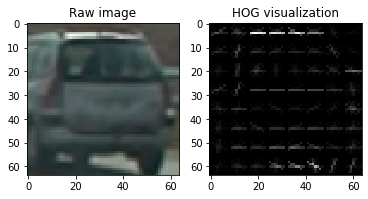

In [2]:
import cv2
from skimage.feature import hog
import numpy as np
pix_per_cell = 8
cell_per_block = 2
orient = 9

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False,
                     feature_vec=False):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=True, 
                                  visualize= vis, feature_vector= feature_vec)
    
    
    
image = mpimg.imread(car_list[0])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, True)
print(features.shape)

# plot example images with extracted HOG visualization
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[0].set_title('Raw image')
axarr[1].imshow(hog_image, cmap='gray')
axarr[1].set_title('HOG visualization')



In [3]:
def get_features_from_list(image_path_list):
    feature_list = []
    for image_path in image_path_list:
        image = mpimg.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        feature_vec = get_hog_features(gray, orient, pix_per_cell, cell_per_block)
        feature_list.append(np.ravel(feature_vec))
    return feature_list
    
car_features = get_features_from_list(car_list)
print(len(car_features))
print(car_features[0].shape)
not_car_features = get_features_from_list(not_car_list)
print(len(not_car_features))
print((not_car_features[0].shape))

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(not_car_features))))

# Create an array stack of feature vectors
X = np.vstack((car_features, not_car_features)).astype(np.float64)
        



8792
(1764,)
8968
(1764,)


# Train a SVM classifier

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import SVC

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to both X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


# Use a SVC 
svc = SVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

127.77 Seconds to train SVC...
Test Accuracy of SVC =  0.9941
My SVC predicts:  [0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
For these 10 labels:  [0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
0.06696 Seconds to predict 10 labels with SVC
